# Business Process Mining Project 
### by Ana Drmic and Leonardo Marazzi

## Description of the project

The project involves embedding the ML framework for business process prediction and anomaly detection inside a notebook that can be used and re-used for both encoding the data and building a ML model.

The idea is to facilitate the building of different models, starting rom log encoding to model building, and then comparing them with each oher.
Our proposal is to have the notebook divided in to 4 parts:

1 Data Loading and Visualization

2 Encoding 

3 Model Building and Training 

4 Model Comparison

The model building has been implemented with an AutoML lybrary: h2o. This solution was chosen to build a viable framework to create models for business process mining and to find the best models without spending too much time on the parameter tuning.son




## Imports

In [1]:
import pandas as pd
import statistics
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from function import Utils
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pandas.api.types import is_numeric_dtype
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from IPython.display import display
warnings.filterwarnings('ignore')

## Data loading

In [2]:
df = pd.read_csv("hmw/Sampled_BPIC17_offer_log.csv")

## Preprocessing

In the first section we wanted to map the most important featur that are mandatory to the logs:

-caseid

-activity

-resource

-ts (time stamp)

-y (target of the Machine learning study)

We then change the name of the columns to be able to use them automaticly

In [3]:
input = {
    "Case ID" : "caseid",
    "Activity" : "activity" ,
    "Resource" : "resource" ,
    "Complete Timestamp": "ts",
    "(case) Accepted" : "y"  #Needs to be 1 for each Case
}

# Change columns name
df.rename(columns=input,inplace = True)

# Timestamp value in df
df["ts"] = pd.to_datetime(df["ts"])

# This is our first function that calculate for each row the assosiated delta time
df["dt"] = Utils.dt(df) 

df.drop("ts",axis=1,inplace = True)

## Missing value analysis

We plot the persantage of missing value for each column

In [4]:
Utils.persantage_nan(df)

index                            0.000000
caseid                           0.000000
activity                         0.000000
resource                         0.000000
Variant                          0.000000
Variant index                    0.000000
y                                0.000000
(case) ApplicationID             0.000000
(case) CreditScore               0.000000
(case) FirstWithdrawalAmount     0.000000
(case) MonthlyCost               0.000000
(case) NumberOfTerms             0.000000
(case) OfferedAmount             0.000000
(case) Selected                  0.000000
Action                           0.000000
EventID                          0.000000
EventOrigin                      0.000000
OfferID                         22.312464
lifecycle:transition             0.000000
dt                               0.000000
dtype: float64

### Null value Prediction

We builded a function that given the column with null values it will train a random forest and replace the column with the predicted values and add a new column to the DataFrame to show which value are predicted and wich are not.


In [5]:
df,model_null_OfferID = Utils.predict_null_value(colum="OfferID",df=df)

In [6]:
df = Utils.prod_nan_with_treshold(df)
df.head()

,index,caseid,activity,resource,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,...,(case) NumberOfTerms,(case) OfferedAmount,(case) Selected,Action,EventID,EventOrigin,OfferID,lifecycle:transition,dt,OfferID_was_null
0,0,Offer_247135719,O_Create Offer,User_17,Variant 8,8,True,Application_196483749,0,10000.0,...,57,10000.0,False,Created,Offer_247135719,Offer,Offer_247135719,complete,0 days 00:00:03.042000,True
1,1,Offer_247135719,O_Created,User_17,Variant 8,8,True,Application_196483749,0,10000.0,...,57,10000.0,False,statechange,OfferState_124849367,Offer,Offer_247135719,complete,0 days 00:02:12.568000,False
2,2,Offer_247135719,O_Sent (online only),User_17,Variant 8,8,True,Application_196483749,0,10000.0,...,57,10000.0,False,statechange,OfferState_440662877,Offer,Offer_247135719,complete,0 days 00:02:04.704000,False
3,3,Offer_247135719,O_Cancelled,User_17,Variant 8,8,True,Application_196483749,0,10000.0,...,57,10000.0,False,statechange,OfferState_591416028,Offer,Offer_247135719,complete,0 days 00:02:04.704000,False
4,4,Offer_941964966,O_Create Offer,User_17,Variant 1,1,True,Application_196483749,0,4100.0,...,57,10000.0,False,Created,Offer_941964966,Offer,Offer_941964966,complete,0 days 00:00:01.551000,True


## Encoding

### Group by CaseId

Afther we have preprocessed the data we can group by caseid and start working on the encoding

In [7]:
df_grouped = df.groupby(["caseid"]).agg(list).reset_index()

When we group by caseid some columns will have a list of list with only one value per row.

This function efficiently reduce these feature to one single value

In [8]:
df_grouped = Utils.reduce_list_columns(df_grouped)

The following function display the columns that need to be encoded.


In [9]:
Utils.display_columns_to_aggragate(df_grouped)

,activity,resource,Action,EventID,OfferID,dt,OfferID_was_null
0,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_20, User_20, User_20, User_117, User_115]","[Created, statechange, statechange, statechang...","[Offer_1000681710, OfferState_452902905, Offer...","[Offer_1572067737, Offer_1000681710, Offer_100...","[0 days 00:00:01.663000, 0 days 00:00:19.05600...","[True, False, False, False, False]"
1,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_2, User_2, User_2, User_113, User_30]","[Created, statechange, statechange, statechang...","[Offer_1001553250, OfferState_1604351174, Offe...","[Offer_533969936, Offer_1001553250, Offer_1001...","[0 days 00:00:01.188000, 0 days 00:00:15.47200...","[True, False, False, False, False]"
2,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_85, User_85, User_85, User_117, User_118]","[Created, statechange, statechange, statechang...","[Offer_1002136393, OfferState_1608457034, Offe...","[Offer_1456773456, Offer_1002136393, Offer_100...","[0 days 00:00:01.293000, 0 days 00:00:19.55600...","[True, False, False, False, False]"
3,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_49, User_49, User_49, User_113, User_102]","[Created, statechange, statechange, statechang...","[Offer_1002236598, OfferState_1780384890, Offe...","[Offer_329102970, Offer_1002236598, Offer_1002...","[0 days 00:00:01.269000, 0 days 00:00:11.34800...","[True, False, False, False, False]"
4,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_15, User_15, User_15, User_1]","[Created, statechange, statechange, statechange]","[Offer_1002530118, OfferState_1971804832, Offe...","[Offer_776746829, Offer_1002530118, Offer_1002...","[0 days 00:00:01.216000, 0 days 00:00:20.01800...","[True, False, False, False]"
...,...,...,...,...,...,...,...
4995,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_73, User_73, User_73, User_43]","[Created, statechange, statechange, statechange]","[Offer_993689039, OfferState_1192570219, Offer...","[Offer_1468908520, Offer_993689039, Offer_9936...","[0 days 00:00:02.062000, 0 days 00:00:15.96300...","[True, False, False, False]"
4996,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_28, User_28, User_28, User_1]","[Created, statechange, statechange, statechange]","[Offer_993800442, OfferState_1754231388, Offer...","[Offer_1562802810, Offer_993800442, Offer_9938...","[0 days 00:00:01.530000, 0 days 00:00:20.28100...","[True, False, False, False]"
4997,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_19, User_19, User_19, User_116, User_113]","[Created, statechange, statechange, statechang...","[Offer_99473283, OfferState_1945701229, OfferS...","[Offer_275638981, Offer_99473283, Offer_994732...","[0 days 00:00:01.283000, 0 days 00:04:24.72900...","[True, False, False, False, False]"
4998,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_25, User_25, User_25, User_119, User_102]","[Created, statechange, statechange, statechang...","[Offer_995784215, OfferState_1350464436, Offer...","[Offer_1846816998, Offer_995784215, Offer_9957...","[0 days 00:00:02.593000, 0 days 00:00:15.82700...","[True, False, False, False, False]"


Some colomns have no importance in the process so we have to drop them.

Keep in mind that if you leave a column with a lot of unique values it will make the encoding very slow, some times not feasible and may also compromise the ML model.


In [10]:
df_grouped = df_grouped.drop(['EventID','OfferID'],axis=1)
df_grouped = df_grouped.drop(['OfferID_was_null'],axis=1)

In [11]:
df_grouped.head(2)

,caseid,activity,resource,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,(case) MonthlyCost,(case) NumberOfTerms,(case) OfferedAmount,(case) Selected,Action,EventOrigin,lifecycle:transition,dt
0,Offer_1000681710,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_20, User_20, User_20, User_117, User_115]",Variant 2,2,True,Application_2131314372,956,14500.0,200.0,96,16000.0,True,"[Created, statechange, statechange, statechang...",Offer,complete,"[0 days 00:00:01.663000, 0 days 00:00:19.05600..."
1,Offer_1001553250,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_2, User_2, User_2, User_113, User_30]",Variant 2,2,False,Application_1607028451,0,2500.0,175.0,127,17500.0,True,"[Created, statechange, statechange, statechang...",Offer,complete,"[0 days 00:00:01.188000, 0 days 00:00:15.47200..."


## Aggregation encoding

In [12]:
df_grouped_agg = Utils.aggregation_encoding(df_grouped,df)

In [13]:
df_grouped_agg.head()

,caseid,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,(case) MonthlyCost,(case) NumberOfTerms,(case) OfferedAmount,...,User_86,User_142,User_76,User_141,User_32,Created,statechange,avg_dt,max_dt,min_dt
0,Offer_1000681710,Variant 2,2,True,Application_2131314372,956,14500.0,200.00,96,16000.0,...,0.0,0.0,0.0,0.0,0.0,0.20,0.80,1 days 11:21:59.362200,7 days 04:11:16.866000,0 days 00:00:01.663000
1,Offer_1001553250,Variant 2,2,False,Application_1607028451,0,2500.0,175.00,127,17500.0,...,0.0,0.0,0.0,0.0,0.0,0.20,0.80,2 days 22:47:28.444400,6 days 13:57:17.486000,0 days 00:00:01.188000
2,Offer_1002136393,Variant 2,2,True,Application_638926349,969,6500.0,343.25,20,6500.0,...,0.0,0.0,0.0,0.0,0.0,0.20,0.80,5 days 22:58:29.630800,18 days 00:58:56.495000,0 days 00:00:01.293000
3,Offer_1002236598,Variant 3,3,False,Application_818693455,0,2500.0,210.00,127,21000.0,...,0.0,0.0,0.0,0.0,0.0,0.20,0.80,1 days 20:42:58.900800,3 days 03:26:35.948000,0 days 00:00:01.269000
4,Offer_1002530118,Variant 1,1,False,Application_1126987739,0,19750.0,210.12,120,20000.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.75,15 days 06:47:37.585000,30 days 13:35:04.553000,0 days 00:00:01.216000


## Index encoding

In [14]:
df_grouped_index = Utils.index_encoding(df_grouped,df,columns_to_encode = ["activity","resource","Action"])

## Model Building

To train the model we decided to implement a Auto Machine learning library h20o: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html

We chose this library beacuse it is built around java that will parallelise the training as much as possible, making the process much faster.

In [15]:
import h2o
from h2o.automl import H2OAutoML
from h2o.automl import H2OAutoML

Select the dataframe you want to use

In [16]:
df_grouped = df_grouped_index.copy()

We first initialize the istance of h2o

In [17]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,49 secs
H2O_cluster_timezone:,Europe/Rome
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,"28 days, 8 hours and 1 minute"
H2O_cluster_name:,anadrmic
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [19]:
df_grouped

,caseid,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,(case) MonthlyCost,(case) NumberOfTerms,(case) OfferedAmount,...,Created_1,statechange_1,Created_2,statechange_2,Created_3,statechange_3,Created_4,statechange_4,Created_5,statechange_5
0,Offer_1000681710,Variant 2,2,True,Application_2131314372,956,14500.0,200.00,96,16000.0,...,1,1,1,1,1,1,1,1,1,1
1,Offer_1001553250,Variant 2,2,False,Application_1607028451,0,2500.0,175.00,127,17500.0,...,1,1,1,1,1,1,1,1,1,1
2,Offer_1002136393,Variant 2,2,True,Application_638926349,969,6500.0,343.25,20,6500.0,...,1,1,1,1,1,1,1,1,1,1
3,Offer_1002236598,Variant 3,3,False,Application_818693455,0,2500.0,210.00,127,21000.0,...,1,1,1,1,1,1,1,1,1,1
4,Offer_1002530118,Variant 1,1,False,Application_1126987739,0,19750.0,210.12,120,20000.0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Offer_993689039,Variant 1,1,True,Application_1786368292,0,1500.0,98.86,66,5500.0,...,1,1,1,1,1,1,1,1,1,1
4996,Offer_993800442,Variant 1,1,True,Application_1082798467,0,13000.0,392.88,36,13000.0,...,1,1,1,1,1,1,1,1,1,1
4997,Offer_99473283,Variant 2,2,False,Application_1183967721,817,5500.0,98.86,66,5500.0,...,1,1,1,1,1,1,1,1,1,1
4998,Offer_995784215,Variant 2,2,True,Application_54468310,1051,6000.0,200.00,127,20000.0,...,1,1,1,1,1,1,1,1,1,1


In [25]:
df_grouped.drop("dt", axis=1, inplace=True)

In [26]:
#Slit dataset into train and test
X_train, X_test = train_test_split(df_grouped, test_size=0.3)

#cast df into h2o DF
df_h_train = h2o.H2OFrame(X_train)
df_h_test = h2o.H2OFrame(X_test)

#select the columns for training and testing
x = df_h_train.columns
y = "y"
x.remove(y)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [27]:
X_train

,caseid,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,(case) MonthlyCost,(case) NumberOfTerms,(case) OfferedAmount,...,Created_1,statechange_1,Created_2,statechange_2,Created_3,statechange_3,Created_4,statechange_4,Created_5,statechange_5
4731,Offer_890605055,Variant 1,1,False,Application_1185170675,0,3021.0,127.30,120,11700.0,...,1,1,1,1,1,1,1,1,1,1
215,Offer_1084780763,Variant 2,2,True,Application_767086253,0,0.0,250.00,74,16000.0,...,1,1,1,1,1,1,1,1,1,1
4474,Offer_787228777,Variant 1,1,True,Application_1561308434,0,0.0,330.00,126,33000.0,...,1,1,1,1,1,1,1,1,1,1
2216,Offer_1835546872,Variant 2,2,True,Application_858441351,906,7603.0,251.73,44,10000.0,...,1,1,1,1,1,1,1,1,1,1
1185,Offer_1447394862,Variant 1,1,False,Application_2071646053,0,2888.0,478.95,72,30000.0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3855,Offer_536472581,Variant 7,7,False,Application_1014824736,0,5000.0,150.00,80,10000.0,...,1,1,1,1,1,1,1,1,1,1
275,Offer_1104585748,Variant 2,2,False,Application_2145834654,732,6500.0,200.00,57,10000.0,...,1,1,1,1,1,1,1,1,1,1
4357,Offer_744566574,Variant 2,2,False,Application_748843249,819,5000.0,849.67,6,5000.0,...,1,1,1,1,1,1,1,1,1,1
1788,Offer_1670203235,Variant 2,2,True,Application_46207219,1014,1000.0,150.00,127,15000.0,...,1,1,1,1,1,1,1,1,1,1


### Classification

In [28]:

#Cast the y in factor for classification this is to be changed if we want to do regression
df_h_train[y] = df_h_train[y].asfactor()
df_h_train[y] = df_h_train[y].asfactor()


#Bluild and train models
aml = H2OAutoML(max_models=15, seed=1,max_runtime_secs= 120)
aml.train(x=x, y=y, training_frame=df_h_train)


AutoML progress: |
00:37:02.527: AutoML: XGBoost is not available; skipping it.
00:37:02.576: _train param, Dropping bad and constant columns: [EventOrigin, statechange_1, statechange_4, statechange_5, statechange_2, statechange_3, Created_3, Created_4, Created_5, t_2, Created_1, t_1, Created_2, t_4, t_3, t_5, caseid, O_Create Offer_5, O_Created_1, O_Create Offer_3, O_Created_2, O_Create Offer_4, lifecycle:transition, O_Create Offer_1, O_Created_3, O_Create Offer_2, O_Created_4, O_Created_5]

███████████████████████
00:37:47.759: _train param, Dropping bad and constant columns: [EventOrigin, statechange_1, statechange_4, statechange_5, statechange_2, statechange_3, Created_3, Created_4, Created_5, t_2, Created_1, t_1, Created_2, t_4, t_3, t_5, caseid, O_Create Offer_5, O_Created_1, O_Create Offer_3, O_Created_2, O_Create Offer_4, lifecycle:transition, O_Create Offer_1, O_Created_3, O_Create Offer_2, O_Created_4, O_Created_5]

█████
00:37:57.4: _train param, Dropping bad and constant co

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20240118_03702


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    42                 42                          83167                  10           10           10            45            151           86.5476

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05419934366275042
RMSE: 0.23280752492724632
LogLoss: 0.22362831121709856
Mean Per-Class Error: 0.037566877576797504
AUC: 0.9952144923262077
AUCPR: 0.9977404412408468
Gini: 0.9904289846524155

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6155215302451573
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  1079     57      0.0502   (57.0/1136.0)
True   59       2305    0.025    (59.0/2364.0)
Total  1138     2362    0.0331   (116.0/3500.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.615522     0.975455  196
max f2                       0.53265      0.981116  220
max f0point5                 0.662154     0.982112  181
max accuracy                 0.615522     0.966857  196
max precision                0.984264     1         0
max recall                   0.338427     1         279
max specificity              0.984264     1         0
max absolute_mcc             0.639028     0.924539  189
max min_per_class_accuracy   0.649371     0.965669  186
max mean_per_class_accuracy  0.662154     0.967989  181
max tns                      0.984264     1136      0
max fns                      0.984264     2362      0
max fps                      0.0302635    1136      399
max tps                      0.338427     2364      279
max tnr                      0.984264     1         0
max fnr                      0.984264     0.999154  0
max fpr                      0.0302635    1         399
max tpr                      0.338427     1         279

Gains/Lift Table: Avg response rate: 67.54 %, avg score: 67.75 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.97274            1.48054   1.48054            1                0.976089  1                           0.976089            0.0148054       0.0148054                  48.0541   48.0541            0.0148054
2        0.02                        0.96815            1.48054   1.48054            1                0.970399  1                           0.973244            0.0148054       0.0296108                  48.0541   48.0541            0.0296108
3        0.03                        0.965819           1.48054   1.48054            1                0.967031  1                           0.971173            0.0148054       0.0444162                  48.0541   48.0541            0.0444162
4        0.04                        0.962614           1.48054   1.48054            1                0.964293  1                           0.969453            0.0148054       0.0592217                  48.0541   48.0541            0.0592217
5        0.05                        0.959604           1.48054   1.48054            1                0.961438  1             

Now we have all the models inside the aml object.
This object is the core of the autoML library and we can do almost everything.

#### Leaderboard

In [29]:
lb = aml.leaderboard
lb.head(rows=lb.nrows) 

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_4_AutoML_1_20240118_03702,0.812059,0.484662,0.877576,0.293861,0.394603,0.155712
GBM_1_AutoML_1_20240118_03702,0.810586,0.493029,0.87425,0.27174,0.399831,0.159865
GBM_3_AutoML_1_20240118_03702,0.809071,0.486025,0.8733,0.308855,0.395905,0.156741
GBM_grid_1_AutoML_1_20240118_03702_model_1,0.803862,0.508829,0.880605,0.316234,0.408735,0.167064
GBM_2_AutoML_1_20240118_03702,0.799468,0.494568,0.87089,0.304248,0.400906,0.160726
GBM_5_AutoML_1_20240118_03702,0.795435,0.499517,0.869268,0.323436,0.403673,0.162952
GBM_grid_1_AutoML_1_20240118_03702_model_2,0.787397,0.508905,0.864123,0.330073,0.408501,0.166873
GBM_grid_1_AutoML_1_20240118_03702_model_3,0.774084,0.52108,0.856639,0.345249,0.414675,0.171955
DRF_1_AutoML_1_20240118_03702,0.724891,0.561681,0.83003,0.398152,0.435029,0.189251
GLM_1_AutoML_1_20240118_03702,0.705359,0.580427,0.815585,0.44412,0.440865,0.194362


Select the best model

In [30]:
model = aml.leader

#### Training curve

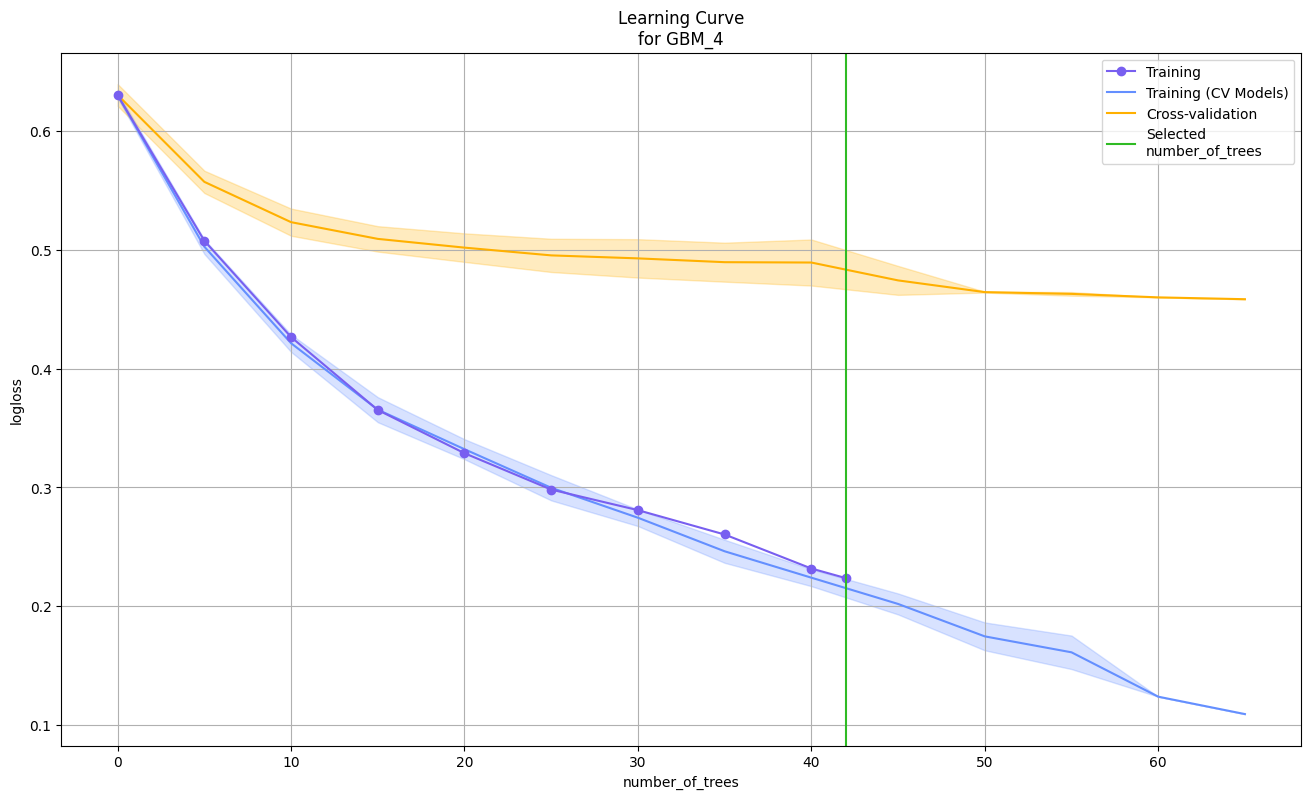

In [31]:
learning_curve_plot = model.learning_curve_plot()

#### Check performance

In [32]:
perf = model.model_performance(df_h_test)
print(perf.accuracy()[0][1])
perf.confusion_matrix()

0.8046666666666666


,False,True,Error,Rate
False,233.0,231.0,0.4978,(231.0/464.0)
True,64.0,972.0,0.0618,(64.0/1036.0)
Total,297.0,1203.0,0.1967,(295.0/1500.0)


#### Model Explainability

Feature importance of a specific model

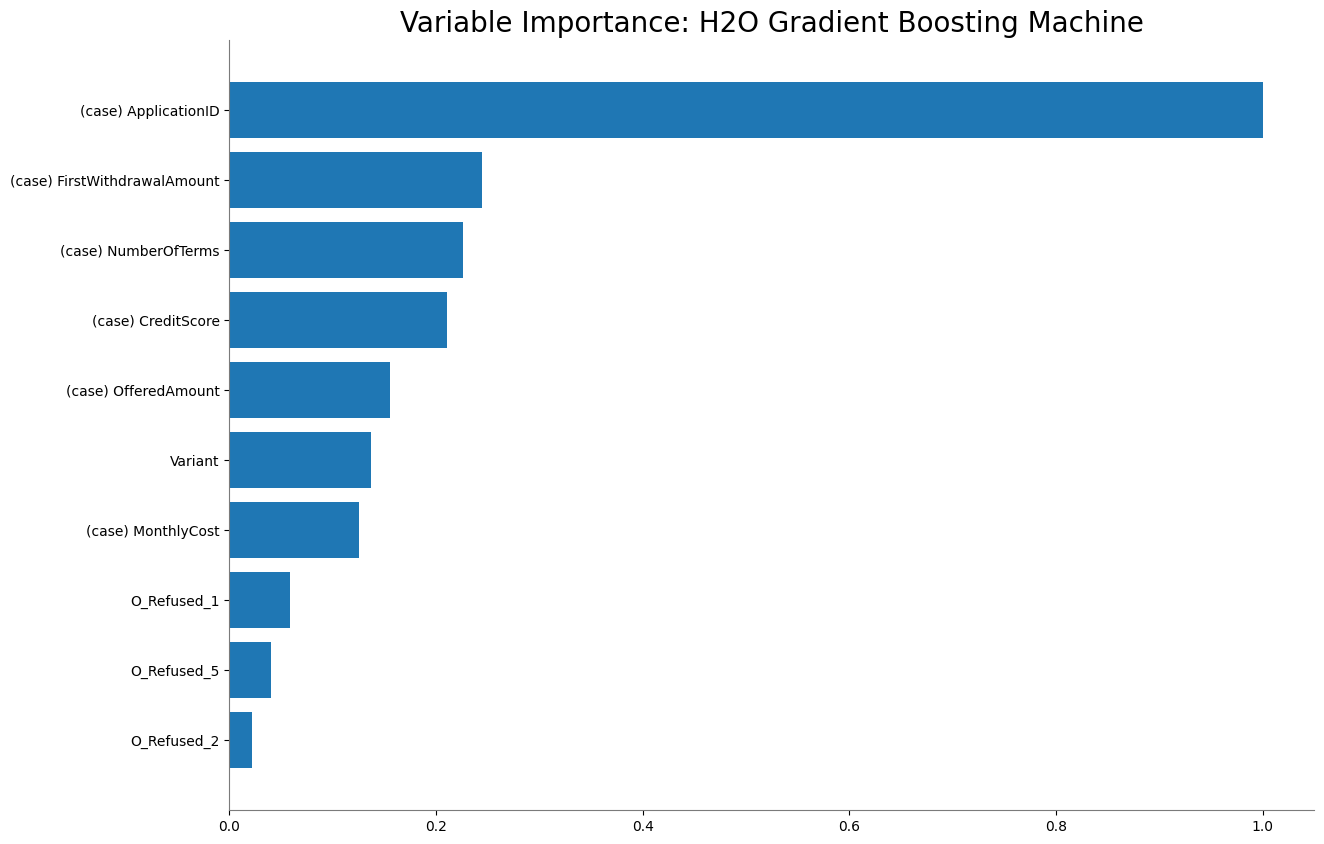

<Figure size 640x480 with 0 Axes>

In [35]:
h2o.get_model("GBM_4_AutoML_1_20240118_03702").varimp_plot()

Show feature importance between all the models

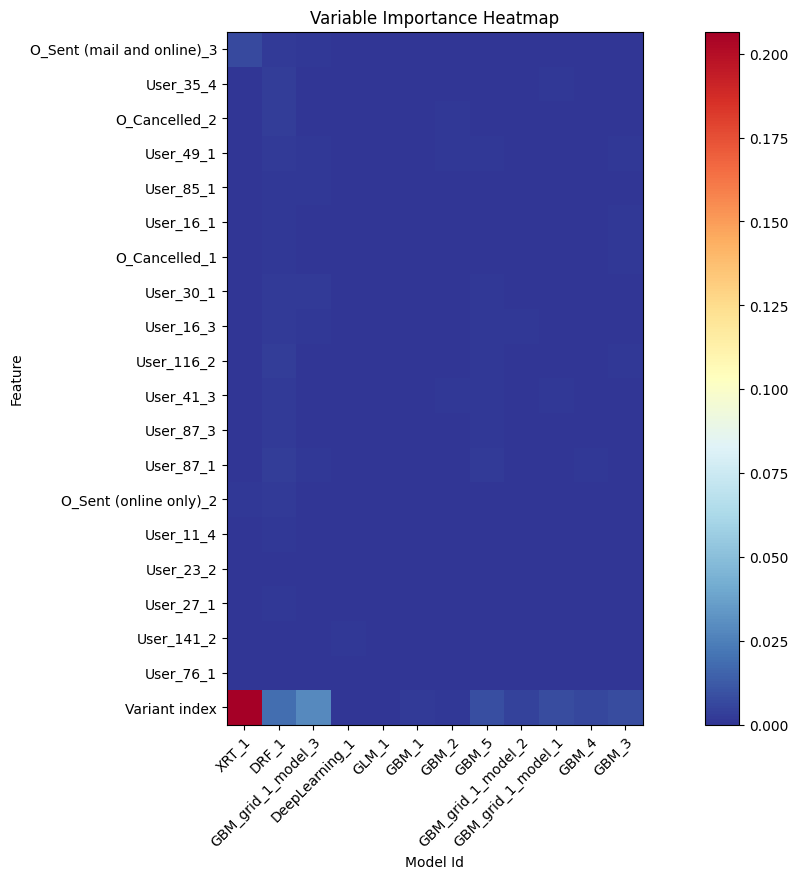

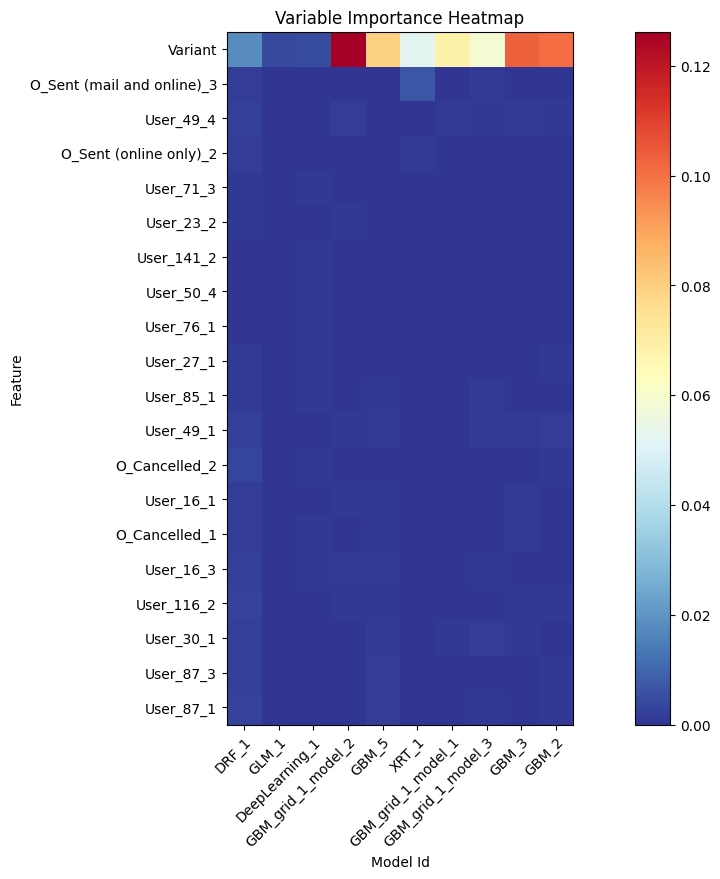

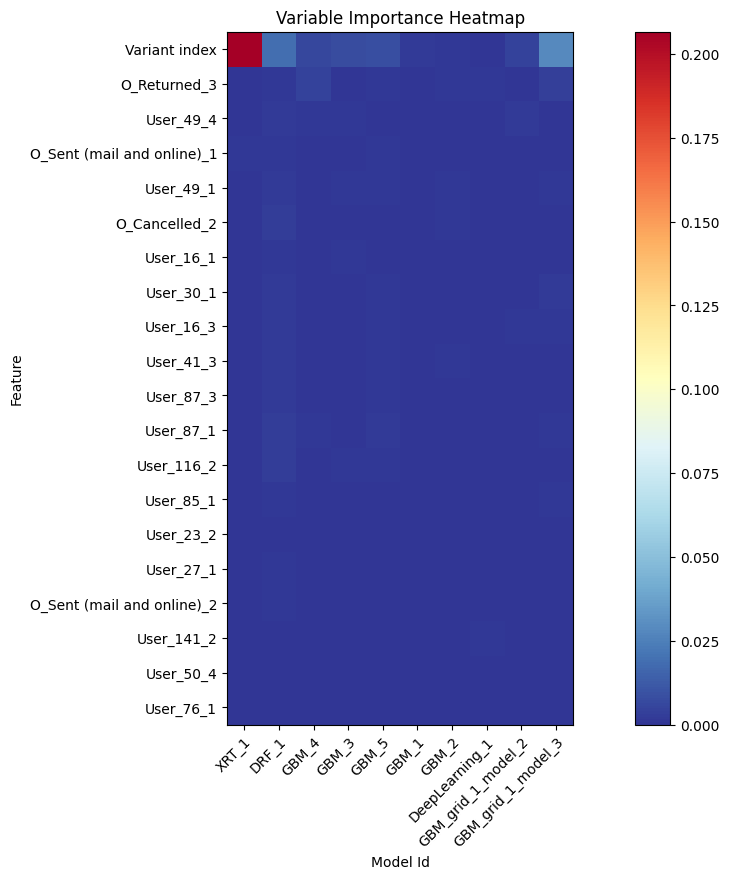

In [36]:
va_plot = aml.varimp_heatmap()

va_plot = h2o.varimp_heatmap(aml.leaderboard.sort("auc").head(10))

# or even extended leaderboard can be used
va_plot = h2o.varimp_heatmap(h2o.automl.get_leaderboard(aml, extra_columns="training_time_ms").sort("training_time_ms").head(10))

## Model Retraining 

We can then retrain the model taking out the less important features

In [46]:
df = pd.read_csv("hmw/Sampled_BPIC17_offer_log.csv")

input = {
    "Case ID" : "caseid",
    "Activity" : "activity" ,
    "Resource" : "resource" ,
    "Complete Timestamp": "ts",
    "(case) Accepted" : "y"  #Needs to be 1 for each Case
}

# Change columns name
df.rename(columns=input,inplace = True)

# Timestamp value in df
df["ts"] = pd.to_datetime(df["ts"])

df["dt"] = Utils.dt(df) # Thisneed to be improved
df.drop("ts",axis=1,inplace = True)

##DROP THE USLESS COLUMNS
df.drop("resource",axis=1,inplace = True)

df,model = Utils.predict_null_value(colum="OfferID",df=df)

df = Utils.prod_nan_with_treshold(df)

df_grouped = df.groupby(["caseid"]).agg(list).reset_index()
df_grouped = Utils.reduce_list_columns(df_grouped)
df_grouped = df_grouped.drop(['EventID','OfferID'],axis=1)
df_grouped = df_grouped.drop(['OfferID_was_null'],axis=1)
df_grouped_agg = Utils.aggregation_encoding(df_grouped,df)

In [47]:
df_grouped_agg["max_dt"] = df_grouped_agg["max_dt"].map(lambda x : x.seconds)
df_grouped_agg["min_dt"] = df_grouped_agg["min_dt"].map(lambda x : x.seconds)
df_grouped_agg["avg_dt"] = df_grouped_agg["avg_dt"].map(lambda x : x.seconds)

In [48]:
h2o.init()

X_train, X_test = train_test_split(df_grouped_agg, test_size=0.3)

df_h_train = h2o.H2OFrame(X_train)
df_h_test = h2o.H2OFrame(X_test)


x = df_h_train.columns
y = "y"
x.remove(y)


df_h_train[y] = df_h_train[y].asfactor()
df_h_train[y] = df_h_train[y].asfactor()

aml = H2OAutoML(nfolds = 10, max_models=15, seed=1,max_runtime_secs= 120,balance_classes=True)
aml.train(x=x, y=y, training_frame=df_h_train)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,17 mins 20 secs
H2O_cluster_timezone:,Europe/Rome
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,"28 days, 8 hours and 18 minutes"
H2O_cluster_name:,anadrmic
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.684 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
00:49:52.81: AutoML: XGBoost is not available; skipping it.
00:49:52.90: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█████████████████████
00:50:33.181: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

██
00:50:35.602: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
00:50:39.234: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

██
00:50:41.67: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
00:50:44.326: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
00:50:46.952: _train param, Dropping bad and consta

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_3_20240118_04952


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    45                 45                          23887                  7            15           10.7556       27            31            28.9333

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1164875049227862
RMSE: 0.3413026588275957
LogLoss: 0.3772479338659479
Mean Per-Class Error: 0.0857589664041277
AUC: 0.9715371812146005
AUCPR: 0.974138484993952
Gini: 0.9430743624292011

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6853447610395167
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  2193     212     0.0881   (212.0/2405.0)
True   199      2188    0.0834   (199.0/2387.0)
Total  2392     2400    0.0858   (411.0/4792.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.685345     0.914142  161
max f2                       0.606395     0.931738  191
max f0point5                 0.77361      0.935706  126
max accuracy                 0.70221      0.914441  155
max precision                0.978808     1         0
max recall                   0.204764     1         356
max specificity              0.978808     1         0
max absolute_mcc             0.70221      0.829007  155
max min_per_class_accuracy   0.687563     0.912682  160
max mean_per_class_accuracy  0.69843      0.914414  156
max tns                      0.978808     2405      0
max fns                      0.978808     2376      0
max fps                      0.0744615    2405      399
max tps                      0.204764     2387      356
max tnr                      0.978808     1         0
max fnr                      0.978808     0.995392  0
max fpr                      0.0744615    1         399
max tpr                      0.204764     1         356

Gains/Lift Table: Avg response rate: 49.81 %, avg score: 62.60 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100167                   0.971046           2.00754     2.00754            1                0.975132  1                           0.975132            0.0201089       0.0201089                  100.754   100.754            0.0201089
2        0.0200334                   0.96534            2.00754     2.00754            1                0.968086  1                           0.971609            0.0201089       0.0402178                  100.754   100.754            0.0402178
3        0.0300501                   0.962077           2.00754     2.00754            1                0.963971  1                           0.969063            0.0201089       0.0603268                  100.754   100.754            0.0603268
4        0.0400668                   0.957994           2.00754     2.00754            1                0.959897  1                           0.966772            0.0201089       0.0804357                  100.754   100.754            0.0804357
5        0.0500835                   0.954287           2.00754     2.00754            1                0.955945  1   

In [49]:
aml.leaderboard.head(5)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_3_20240118_04952,0.808261,0.497358,0.880099,0.284542,0.401997,0.161602
GBM_3_AutoML_3_20240118_04952,0.803664,0.501437,0.878702,0.285137,0.402645,0.162123
GBM_4_AutoML_3_20240118_04952,0.803319,0.508357,0.881147,0.315936,0.406228,0.165021
GBM_2_AutoML_3_20240118_04952,0.802576,0.499779,0.877614,0.31087,0.40303,0.162433
GBM_grid_1_AutoML_3_20240118_04952_model_1,0.79917,0.528324,0.873701,0.308533,0.416076,0.173119


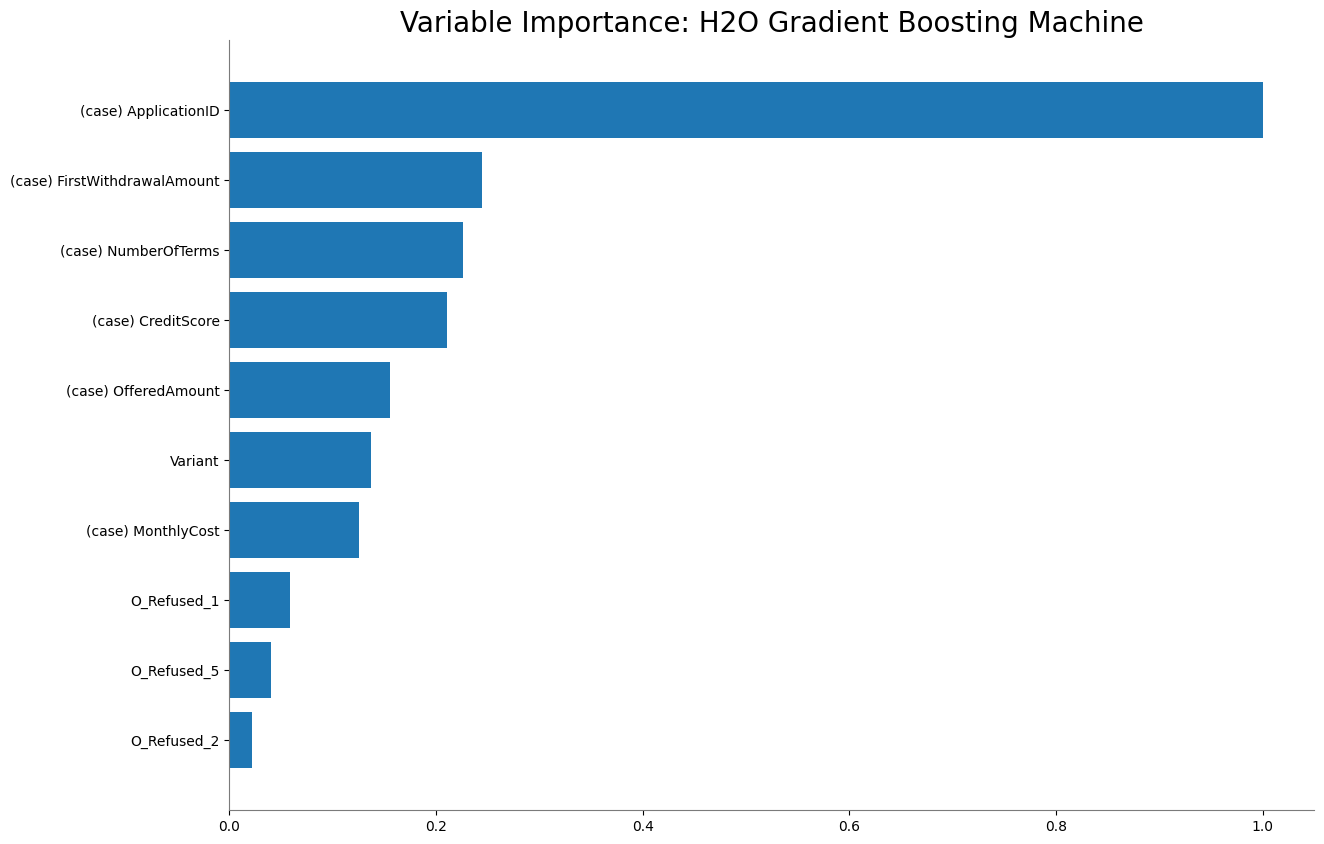

<Figure size 640x480 with 0 Axes>

In [50]:
h2o.get_model("GBM_4_AutoML_1_20240118_03702").varimp_plot()

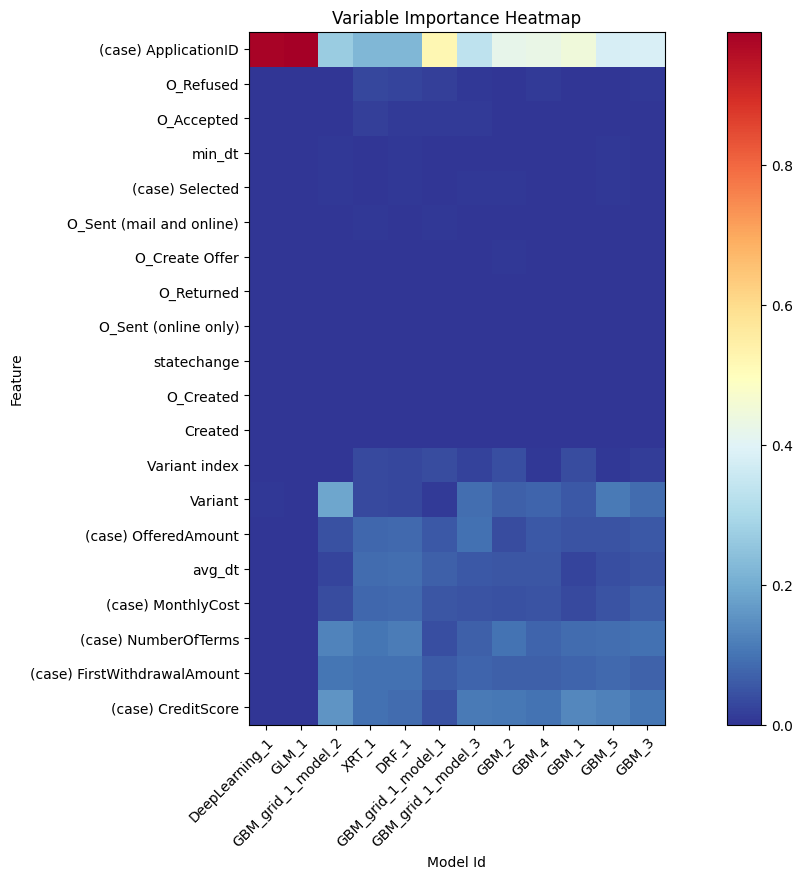

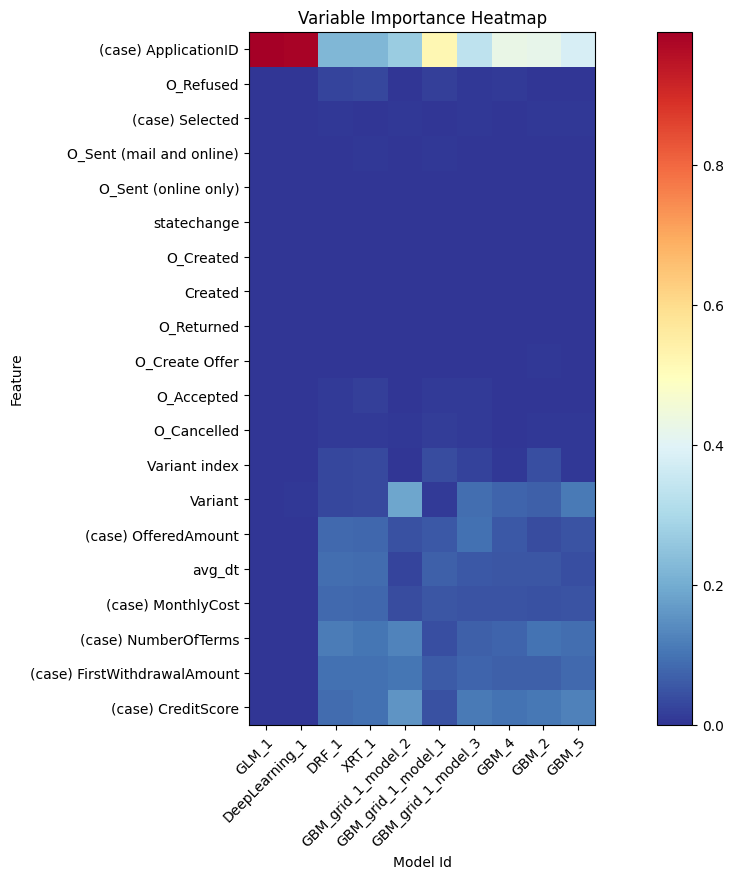

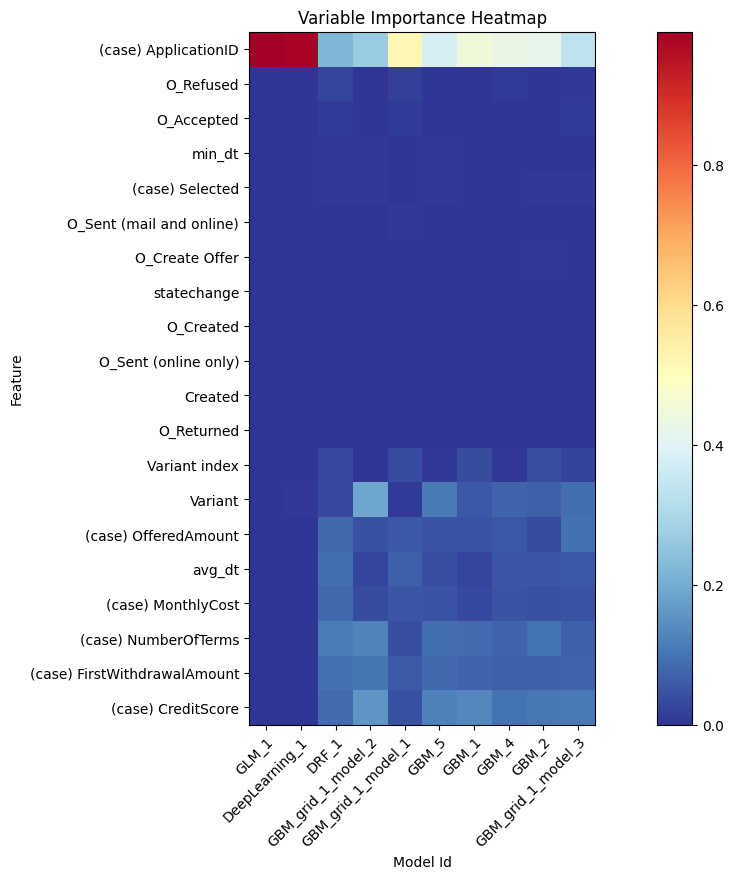

In [51]:
va_plot = aml.varimp_heatmap()

# or if some subset of the models is needed a slice of leaderboard can be used, e.g., using MAE as the sorting metric
va_plot = h2o.varimp_heatmap(aml.leaderboard.sort("auc").head(10))

# or even extended leaderboard can be used
va_plot = h2o.varimp_heatmap(h2o.automl.get_leaderboard(aml, extra_columns="training_time_ms").sort("training_time_ms").head(10))

## Evaluation of results

In [52]:
model_2 = aml.leader
perf = model_2.model_performance(df_h_test)
print(perf.accuracy()[0][1])
perf.confusion_matrix()

0.7926666666666666


,False,True,Error,Rate
False,271.0,216.0,0.4435,(216.0/487.0)
True,95.0,918.0,0.0938,(95.0/1013.0)
Total,366.0,1134.0,0.2073,(311.0/1500.0)
